The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Designing Convolution Network Architectures
:label:`sec_cnn-design`

The previous sections have taken us on a tour of modern network design for computer vision. Common to all the work we covered was that it greatly relied on the intuition of scientists. Many of the architectures are heavily informed by human creativity and to a much lesser extent by systematic exploration of the design space that deep networks offer. Nonetheless, this *network engineering* approach has been tremendously successful. 

Ever since AlexNet (:numref:`sec_alexnet`)
beat conventional computer vision models on ImageNet,
it has become popular to construct very deep networks
by stacking blocks of convolutions, all designed according to the same pattern. 
In particular, $3 \times 3$ convolutions were 
popularized by VGG networks (:numref:`sec_vgg`).
NiN (:numref:`sec_nin`) showed that even $1 \times 1$ convolutions could 
be beneficial by adding local nonlinearities. 
Moreover, NiN solved the problem of aggregating information at the head of a network 
by aggregating across all locations. 
GoogLeNet (:numref:`sec_googlenet`) added multiple branches of different convolution width, 
combining the advantages of VGG and NiN in its Inception block. 
ResNets (:numref:`sec_resnet`) 
changed the inductive bias towards the identity mapping (from $f(x) = 0$). This allowed for very deep networks. Almost a decade later, the ResNet design is still popular, a testament to its design. Lastly, ResNeXt (:numref:`subsec_resnext`) added grouped convolutions, offering a better trade-off between parameters and computation. A precursor to Transformers for vision, the Squeeze-and-Excitation Networks (SENets) allow for efficient information transfer between locations
:cite:`Hu.Shen.Sun.2018`. This was accomplished by computing a per-channel global attention function. 

Up to now we have omitted networks obtained via *neural architecture search* (NAS) :cite:`zoph2016neural,liu2018darts`. We chose to do so since their cost is usually enormous, relying on brute-force search, genetic algorithms, reinforcement learning, or some other form of hyperparameter optimization. Given a fixed search space,
NAS uses a search strategy to automatically select
an architecture based on the returned performance estimation.
The outcome of NAS
is a single network instance. EfficientNets are a notable outcome of this search :cite:`tan2019efficientnet`.

In the following we discuss an idea that is quite different to the quest for the *single best network*. It is computationally relatively inexpensive, it leads to scientific insights on the way, and it is quite effective in terms of the quality of outcomes. Let's review the strategy by :citet:`Radosavovic.Kosaraju.Girshick.ea.2020` to *design network design spaces*. The strategy combines the strength of manual design and NAS. It accomplishes this by operating on *distributions of networks* and optimizing the distributions in a way to obtain good performance for entire families of networks. The outcome of it are *RegNets*, specifically RegNetX and RegNetY, plus a range of guiding principles for the design of performant CNNs.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## The AnyNet Design Space
:label:`subsec_the-anynet-design-space`

The description below closely follows the reasoning in :citet:`Radosavovic.Kosaraju.Girshick.ea.2020` with some abbreviations to make it fit in the scope of the book. 
To begin, we need a template for the family of networks to explore. One of the commonalities of the designs in this chapter is that the networks consist of a *stem*, a *body* and a *head*. The stem performs initial image processing, often through convolutions with a larger window size. The body consists of multiple blocks, carrying out the bulk of the transformations needed to go from raw images to object representations. Lastly, the head converts this into the desired outputs, such as via a softmax regressor for multiclass classification. 
The body, in turn, consists of multiple stages, operating on the image at decreasing resolutions. In fact, both the stem and each subsequent stage quarter the spatial resolution. Lastly, each stage consists of one or more blocks. This pattern is common to all networks, from VGG to ResNeXt. Indeed, for the design of generic AnyNet networks, :citet:`Radosavovic.Kosaraju.Girshick.ea.2020` used the ResNeXt block of :numref:`fig_resnext_block`.


![The AnyNet design space. The numbers $(\mathit{c}, \mathit{r})$ along each arrow indicate the number of channels $c$ and the resolution $\mathit{r} \times \mathit{r}$ of the images at that point. From left to right: generic network structure composed of stem, body, and head; body composed of four stages; detailed structure of a stage; two alternative structures for blocks, one without downsampling and one that halves the resolution in each dimension. Design choices include depth $\mathit{d_i}$, the number of output channels $\mathit{c_i}$, the number of groups $\mathit{g_i}$, and bottleneck ratio $\mathit{k_i}$ for any stage $\mathit{i}$.](http://d2l.ai/_images/anynet.svg)
:label:`fig_anynet_full`

Let's review the structure outlined in :numref:`fig_anynet_full` in detail. As mentioned, an AnyNet consists of a stem, body, and head. The stem takes as its input RGB images (3 channels), using a $3 \times 3$ convolution with a stride of $2$, followed by a batch norm, to halve the resolution from $r \times r$ to $r/2 \times r/2$. Moreover, it generates $c_0$ channels that serve as input to the body. 

Since the network is designed to work well with ImageNet images of shape $224 \times 224 \times 3$, the body serves to reduce this to $7 \times 7 \times c_4$ through 4 stages (recall that $224 / 2^{1+4} = 7$), each with an eventual stride of $2$. Lastly, the head employs an entirely standard design via global average pooling, similar to NiN (:numref:`sec_nin`), followed by a fully connected layer to emit an $n$-dimensional vector for $n$-class classification. 

Most of the relevant design decisions are inherent to the body of the network. It proceeds in stages, where each stage is composed of the same type of ResNeXt blocks as we discussed in :numref:`subsec_resnext`. The design there is again entirely generic: we begin with a block that halves the resolution by using a stride of $2$ (the rightmost in :numref:`fig_anynet_full`). To match this, the residual branch of the ResNeXt block needs to pass through a $1 \times 1$ convolution. This block is followed by a variable number of additional ResNeXt blocks that leave both resolution and the number of channels unchanged. Note that a common design practice is to add a slight bottleneck in the design of convolutional blocks. 
As such, with bottleneck ratio $k_i \geq 1$ we afford some number of channels, $c_i/k_i$,  within each block for stage $i$ (as the experiments show, this is not really effective and should be skipped). Lastly, since we are dealing with ResNeXt blocks, we also need to pick the number of groups $g_i$ for grouped convolutions at stage $i$. 

This seemingly generic design space provides us nonetheless with many parameters: we can set the block width (number of channels) $c_0, \ldots c_4$, the depth (number of blocks) per stage $d_1, \ldots d_4$, the bottleneck ratios $k_1, \ldots k_4$, and the group widths (numbers of groups) $g_1, \ldots g_4$. 
In total this adds up to 17 parameters, resulting in an unreasonably large number of configurations that would warrant exploring. We need some tools to reduce this huge design space effectively. This is where the conceptual beauty of design spaces comes in. Before we do so, let's implement the generic design first.


In [2]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

Each stage consists of `depth` ResNeXt blocks,
where `num_channels` specifies the block width.
Note that the first block halves the height and width of input images.


In [3]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

Putting the network stem, body, and head together,
we complete the implementation of AnyNet.


In [4]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## Distributions and Parameters of Design Spaces

As just discussed in :numref:`subsec_the-anynet-design-space`, parameters of a design space are hyperparameters of networks in that design space.
Consider the problem of identifying good parameters in the AnyNet design space. We could try finding the *single best* parameter choice for a given amount of computation (e.g., FLOPs and compute time). If we allowed for even only *two* possible choices for each parameter, we would have to explore $2^{17} = 131072$ combinations to find the best solution. This is clearly infeasible because of its exorbitant cost. Even worse, we do not really learn anything from this exercise in terms of how one should design a network. Next time we add, say, an X-stage, or a shift operation, or similar, we would need to start from scratch. Even worse, due to the stochasticity in training (rounding, shuffling, bit errors), no two runs are likely to produce exactly the same results. A better strategy would be to try to determine general guidelines of how the choices of parameters should be related. For instance, the bottleneck ratio, the number of channels, blocks, groups, or their change between layers should ideally be governed by a collection of simple rules. The approach in :citet:`radosavovic2019network` relies on the following four assumptions:

1. We assume that general design principles actually exist, so that many networks satisfying these requirements should offer good performance. Consequently, identifying a *distribution* over networks can be a sensible strategy. In other words, we assume that there are many good needles in the haystack.
1. We need not train networks to convergence before we can assess whether a network is good. Instead, it is sufficient to use the intermediate results as reliable guidance for final accuracy. Using (approximate) proxies to optimize an objective is referred to as multi-fidelity optimization :cite:`forrester2007multi`. Consequently, design optimization is carried out, based on the accuracy achieved after only a few passes through the dataset, reducing the cost significantly. 
1. Results obtained at a smaller scale (for smaller networks) generalize to larger ones. Consequently, optimization is carried out for networks that are structurally similar, but with a smaller number of blocks, fewer channels, etc. Only in the end will we need to verify that the so-found networks also offer good performance at scale. 
1. Aspects of the design can be approximately factorized so that it is possible to infer their effect on the quality of the outcome somewhat independently. In other words, the optimization problem is moderately easy.

These assumptions allow us to test many networks cheaply. In particular, we can *sample* uniformly from the space of configurations and evaluate their performance. Subsequently, we can evaluate the quality of the choice of parameters by reviewing the *distribution* of error/accuracy that can be achieved with said networks. Denote by $F(e)$ the cumulative distribution function (CDF) for errors committed by networks of a given design space, drawn using probability disribution $p$. That is, 

$$F(e, p) \stackrel{\textrm{def}}{=} P_{\textrm{net} \sim p} \{e(\textrm{net}) \leq e\}.$$

Our goal is now to find a distribution $p$ over *networks* such that most networks have a very low error rate and where the support of $p$ is concise. Of course, this is computationally infeasible to perform accurately. We resort to a sample of networks $\mathcal{Z} \stackrel{\textrm{def}}{=} \{\textrm{net}_1, \ldots \textrm{net}_n\}$ (with errors $e_1, \ldots, e_n$, respectively) from $p$ and use the empirical CDF $\hat{F}(e, \mathcal{Z})$ instead:

$$\hat{F}(e, \mathcal{Z}) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(e_i \leq e).$$

Whenever the CDF for one set of choices majorizes (or matches) another CDF it follows that its choice of parameters is superior (or indifferent). Accordingly 
:citet:`Radosavovic.Kosaraju.Girshick.ea.2020` experimented with a shared network bottleneck ratio $k_i = k$ for all stages $i$ of the network. This gets rid of three of the four parameters governing the bottleneck ratio. To assess whether this (negatively) affects the performance one can draw networks from the constrained and from the unconstrained distribution and compare the corresonding CDFs. It turns out that this constraint does not affect the accuracy of the distribution of networks at all, as can be seen in the first panel of :numref:`fig_regnet-fig`. 
Likewise, we could choose to pick the same group width $g_i = g$ occurring at the various stages of the network. Again, this does not affect performance, as can be seen in the second panel of :numref:`fig_regnet-fig`.
Both steps combined reduce the number of free parameters by six. 

![Comparing error empirical distribution functions of design spaces. $\textrm{AnyNet}_\mathit{A}$ is the original design space; $\textrm{AnyNet}_\mathit{B}$ ties the bottleneck ratios, $\textrm{AnyNet}_\mathit{C}$ also ties group widths, $\textrm{AnyNet}_\mathit{D}$ increases the network depth across stages. From left to right: (i) tying bottleneck ratios has no effect on performance; (ii) tying group widths has no effect on performance; (iii) increasing network widths (channels) across stages improves performance; (iv) increasing network depths across stages improves performance. Figure courtesy of :citet:`Radosavovic.Kosaraju.Girshick.ea.2020`.](../img/regnet-fig.png)
:label:`fig_regnet-fig`

Next we look for ways to reduce the multitude of potential choices for width and depth of the stages. It is a reasonable assumption that, as we go deeper, the number of channels should increase, i.e., $c_i \geq c_{i-1}$ ($w_{i+1} \geq w_i$ per their notation in :numref:`fig_regnet-fig`), yielding 
$\textrm{AnyNetX}_D$. Likewise, it is equally reasonable to assume that as the stages progress, they should become deeper, i.e., $d_i \geq d_{i-1}$, yielding $\textrm{AnyNetX}_E$. This can be experimentally verified in the third and fourth panel of :numref:`fig_regnet-fig`, respectively.

## RegNet

The resulting $\textrm{AnyNetX}_E$ design space consists of simple networks
following easy-to-interpret design principles:

* Share the bottleneck ratio $k_i = k$ for all stages $i$;
* Share the group width $g_i = g$ for all stages $i$;
* Increase network width across stages: $c_{i} \leq c_{i+1}$;
* Increase network depth across stages: $d_{i} \leq d_{i+1}$.

This leaves us with a final set of choices: how to pick the specific values for the above parameters of the eventual $\textrm{AnyNetX}_E$ design space. By studying the best-performing networks from the distribution in $\textrm{AnyNetX}_E$ one can observe the following: the width of the network ideally increases linearly with the block index across the network, i.e., $c_j \approx c_0 + c_a j$, where $j$ is the block index and slope $c_a > 0$. Given that we get to choose a different block width only per stage, we arrive at a piecewise constant function, engineered to match this dependence. Furthermore, experiments also show that a bottleneck ratio of $k = 1$ performs best, i.e., we are advised not to use bottlenecks at all. 

We recommend the interested reader reviews further details in the design of specific networks for different amounts of computation by perusing :citet:`Radosavovic.Kosaraju.Girshick.ea.2020`. For instance, an effective 32-layer RegNetX variant is given by $k = 1$ (no bottleneck), $g = 16$ (group width is 16), $c_1 = 32$ and $c_2 = 80$ channels for the first and second stage, respectively, chosen to be $d_1=4$ and $d_2=6$ blocks deep. The astonishing insight from the design is that it still applies, even when investigating networks at a larger scale. Even better, it even holds for Squeeze-and-Excitation (SE) network designs (RegNetY) that have a global channel activation :cite:`Hu.Shen.Sun.2018`.


In [5]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

We can see that each RegNetX stage progressively reduces resolution and increases output channels.


In [6]:
RegNetX32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


## Training

Training the 32-layer RegNetX on the Fashion-MNIST dataset is just like before.


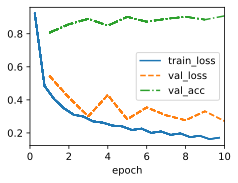

In [7]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## Discussion

With desirable inductive biases (assumptions or preferences) like locality and translation invariance (:numref:`sec_why-conv`)
for vision, CNNs have been the dominant architectures in this area. This remained the case from LeNet up until Transformers (:numref:`sec_transformer`) :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021,touvron2021training` started surpassing CNNs in terms of accuracy. While much of the recent progress in terms of vision Transformers *can* be backported into CNNs :cite:`liu2022convnet`, it is only possible at a higher computational cost. Just as importantly, recent hardware optimizations (NVIDIA Ampere and Hopper) have only widened the gap in favor of Transformers. 

It is worth noting that Transformers have a significantly lower degree of inductive bias towards locality and translation invariance than CNNs. That learned structures prevailed is due, not least, to the availability of large image collections, such as LAION-400m and LAION-5B :cite:`schuhmann2022laion` with up to 5 billion images. Quite surprisingly, some of the more relevant work in this context even includes MLPs :cite:`tolstikhin2021mlp`. 

In sum, vision Transformers (:numref:`sec_vision-transformer`) by now lead in terms of 
state-of-the-art performance in large-scale image classification, 
showing that *scalability trumps inductive biases* :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`.
This includes pretraining large-scale Transformers (:numref:`sec_large-pretraining-transformers`) with multi-head self-attention (:numref:`sec_multihead-attention`). We invite the readers to dive into these chapters for a much more detailed discussion.

## Exercises

1. Increase the number of stages to four. Can you design a deeper RegNetX that performs better?
1. De-ResNeXt-ify RegNets by replacing the ResNeXt block with the ResNet block. How does your new model perform?
1. Implement multiple instances of a "VioNet" family by *violating* the design principles of RegNetX. How do they perform? Which of ($d_i$, $c_i$, $g_i$, $b_i$) is the most important factor?
1. Your goal is to design the "perfect" MLP. Can you use the design principles introduced above to find good architectures? Is it possible to extrapolate from small to large networks?


[Discussions](https://discuss.d2l.ai/t/7463)
